In [51]:
import pandas as pd

def read_csv_files():
    meta_df = pd.read_csv('data/Meta.csv')
    test_df = pd.read_csv('data/Test.csv')
    train_df = pd.read_csv('data/Train.csv')
    return meta_df, test_df, train_df

meta_df, test_df, train_df = read_csv_files()

In [52]:
meta_df.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [53]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [104]:
#Importing essential libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import math
import cv2
import os
import shutil
import pathlib

import tensorflow as tf
from tensorflow import keras

#Fixing python random seed
random.seed(42)
#fixing numpy random seed
np.random.seed(21)
#fixing tensorflow random seed
tf.random.set_seed(42)

In [59]:
# Creating validation directory
val_dir = "data/Validation"
os.mkdir(val_dir)

n_classes = 43
train_dir = "data/Train{0}"

# Moving files from train to validation directory
for n in tqdm(range(n_classes)):
    path = os.path.join(val_dir, str(n))
    os.mkdir(path)
    src_path = train_dir.format('/' + str(n))
    files = os.listdir(src_path)
    rand_idx = random.sample(range(len(files)), math.ceil(len(files) / 4))
    for idx in rand_idx:
        src = src_path + "/" + files[idx]
        shutil.move(src, path)

100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 26.44it/s]


In [60]:
train_csv_path = 'data/Train.csv'
val_dir = 'data/Validation'
new_val_csv_path = 'data/Validation.csv'

val_data = []

# Iterate over the validation directory to find moved images
for class_dir in os.listdir(val_dir):
    class_path = os.path.join(val_dir, class_dir)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            original_path = f'Train/{class_dir}/{img_name}'
            # Find the original entry in train_df
            original_entry = train_df[train_df['Path'] == original_path]
            if not original_entry.empty:
                val_data.append(original_entry.iloc[0])

# Create a DataFrame for validation data
val_df = pd.DataFrame(val_data)

# Save the validation data to a new CSV file
val_df.to_csv(new_val_csv_path, index=False)

print(f'Validation CSV created at: {new_val_csv_path}')

Validation CSV created at: data/Validation.csv


In [61]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9812 entries, 33021 to 29029
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    9812 non-null   int64 
 1   Height   9812 non-null   int64 
 2   Roi.X1   9812 non-null   int64 
 3   Roi.Y1   9812 non-null   int64 
 4   Roi.X2   9812 non-null   int64 
 5   Roi.Y2   9812 non-null   int64 
 6   ClassId  9812 non-null   int64 
 7   Path     9812 non-null   object
dtypes: int64(7), object(1)
memory usage: 689.9+ KB


In [62]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


In [64]:
# Extract the file paths
train_paths = set(train_df['Path'])
val_paths = set(val_df['Path'])

# Find overlapping paths
overlap_paths = train_paths.intersection(val_paths)

# Convert to a list for easy processing
overlap_paths = list(overlap_paths)

In [65]:
# Remove the overlapping entries from the training set DataFrame
train_df_cleaned = train_df[~train_df['Path'].isin(overlap_paths)]

# Save the cleaned DataFrame to a new CSV file
cleaned_train_csv_path = 'data/cleaned_train.csv'  # Define a path for the cleaned training CSV
train_df_cleaned.to_csv(cleaned_train_csv_path, index=False)

print(f"Cleaned training CSV saved at: {cleaned_train_csv_path}")

Cleaned training CSV saved at: data/cleaned_train.csv


In [67]:
# define paths
cleaned_csv_path = 'data/cleaned_train.csv'

# load the datasets
cleaned_train_df = pd.read_csv(cleaned_csv_path)

# Extract the file paths
cleaned_train_paths = set(cleaned_train_df['Path'])

# Find any overlaps
overlap_paths = cleaned_train_paths.intersection(val_paths)

# Report results
if overlap_paths:
    print("Overlap found in the following files:")
    for path in overlap_paths:
        print(path)
else:
    print("No overlap found. Training and validation datasets are distinct.")


No overlap found. Training and validation datasets are distinct.


In [83]:
#preprocessing images
import cv2
from glob import glob
import matplotlib.pylab as plt

In [81]:
img_files_20 = glob('data/Train/0/*.png')

In [84]:
img_files_20_0 = plt.imread(img_files_20[0])

In [87]:
img_files_20_0.shape

(58, 59, 3)

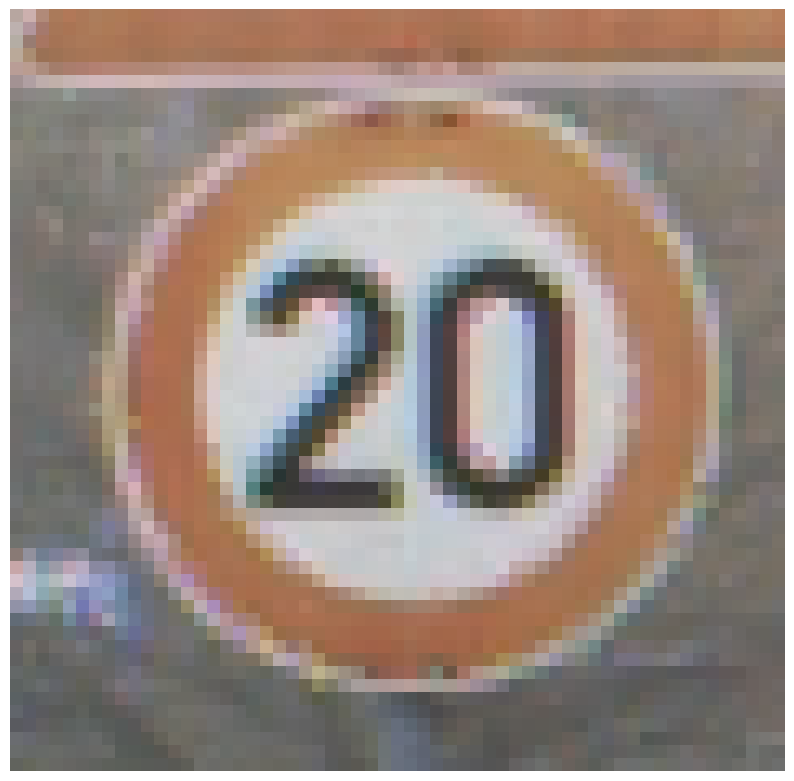

In [90]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(img_files_20_0)
ax.axis('off')
plt.show()

In [92]:
def load_and_preprocess_images(csv_path, base_img_dir, target_size=(32, 32)):
    data = pd.read_csv(csv_path)
    images = []
    labels = []
    for index, row in data.iterrows():
        img_path = os.path.join(base_img_dir, row['Path'])
        img = cv2.imread(img_path)
        if img is not None:
            # resizing image
            img = cv2.resize(img, target_size)
            # normalizing pixel values
            img = img / 255
            images.append(img)
            labels.append(row['ClassId'])
    return np.array(images), np.array(labels)

In [96]:
train_csv_path = 'data/Train.csv'
val_csv_path = 'data/Validation.csv'
test_csv_path = 'data/Test.csv'

base_img_dir = 'data'

X_train, y_train = load_and_preprocess_images(train_csv_path, base_img_dir)
X_val, y_val = load_and_preprocess_images(val_csv_path, base_img_dir)
X_test, y_test = load_and_preprocess_images(test_csv_path, base_img_dir)


print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

[ WARN:0@11164.038] global loadsave.cpp:248 findDecoder imread_('data/Train/32/00032_00005_00021.png'): can't open/read file: check file path/integrity
[ WARN:0@11164.039] global loadsave.cpp:248 findDecoder imread_('data/Train/32/00032_00006_00015.png'): can't open/read file: check file path/integrity
[ WARN:0@11164.039] global loadsave.cpp:248 findDecoder imread_('data/Train/32/00032_00000_00005.png'): can't open/read file: check file path/integrity
[ WARN:0@11164.039] global loadsave.cpp:248 findDecoder imread_('data/Train/32/00032_00000_00004.png'): can't open/read file: check file path/integrity
[ WARN:0@11164.039] global loadsave.cpp:248 findDecoder imread_('data/Train/32/00032_00003_00024.png'): can't open/read file: check file path/integrity
[ WARN:0@11164.039] global loadsave.cpp:248 findDecoder imread_('data/Train/32/00032_00003_00008.png'): can't open/read file: check file path/integrity
[ WARN:0@11164.040] global loadsave.cpp:248 findDecoder imread_('data/Train/32/00032_000

Training set: (29397, 32, 32, 3), (29397,)
Validation set: (0,), (0,)
Test set: (12630, 32, 32, 3), (12630,)


In [97]:
assert X_train.shape[1:] == (32, 32, 3), "Training images are not correctly reshaped."
assert X_val.shape[1:] == (32, 32, 3), "Validation images are not correctly reshaped."
assert X_test.shape[1:] == (32, 32, 3), "Test images are not correctly reshaped."

print("All datasets have been correctly reshaped and are ready for training.")


AssertionError: Validation images are not correctly reshaped.

In [99]:
def modify_path(row):
    old_path = row['Path']
    new_path = old_path.replace('Train', 'Validation')
    return new_path

val_df['Path'] = val_df.apply(modify_path, axis=1)

updated_val_csv_path = 'data/updated_validation.csv'
val_df.to_csv(updated_val_csv_path, index=False)

In [100]:
train_csv_path = 'data/Train.csv'
val_csv_path = 'data/Validation.csv'
test_csv_path = 'data/Test.csv'

base_img_dir = 'data'

X_train, y_train = load_and_preprocess_images(train_csv_path, base_img_dir)
X_val, y_val = load_and_preprocess_images(val_csv_path, base_img_dir)
X_test, y_test = load_and_preprocess_images(test_csv_path, base_img_dir)


print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (29397, 32, 32, 3), (29397,)
Validation set: (9812, 32, 32, 3), (9812,)
Test set: (12630, 32, 32, 3), (12630,)


In [101]:
assert X_train.shape[1:] == (32, 32, 3), "Training images are not correctly reshaped."
assert X_val.shape[1:] == (32, 32, 3), "Validation images are not correctly reshaped."
assert X_test.shape[1:] == (32, 32, 3), "Test images are not correctly reshaped."

print("All datasets have been correctly reshaped and are ready for training.")


All datasets have been correctly reshaped and are ready for training.


In [106]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

model = Sequential([
    Flatten(input_shape = (32, 32, 3)),
    Dense(300, activation = "relu"),
    Dense(100, activation = "relu"),
    Dense(43, activation = "softmax")
])

In [107]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 300)            │       921,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │         4,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 956,343 (3.65 MB)

 Trainable params: 956,343 (3.65 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
hidden1 = model.layers[1]

In [110]:
weights, biases = hidden1.get_weights()

In [113]:
weights.shape

(3072, 300)

In [114]:
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import SGD

model.compile(loss="sparse_categorical_crossentropy",
             optimizer = "sgd",
             metrics = ["accuracy"])

In [115]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2112 - loss: 3.2073 - val_accuracy: 0.4629 - val_loss: 2.2051
Epoch 2/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5321 - loss: 1.9100 - val_accuracy: 0.6157 - val_loss: 1.4602
Epoch 3/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6778 - loss: 1.2800 - val_accuracy: 0.7380 - val_loss: 1.0625
Epoch 4/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7656 - loss: 0.9481 - val_accuracy: 0.7998 - val_loss: 0.8249
Epoch 5/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8147 - loss: 0.7552 - val_accuracy: 0.8359 - val_loss: 0.6759
Epoch 6/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8447 - loss: 0.6322 - val_accuracy: 0.8689 - val_loss: 0.5674
Epoch 7/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8660 - loss: 0.5462 - val_accuracy: 0.8877 - val_loss: 0.5000
Epoch 8/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8822 - loss: 0.4832 - val_accuracy: 0.

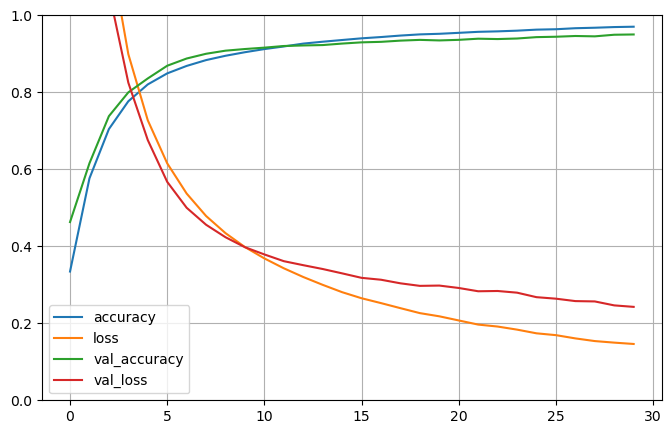

In [116]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) #sets vertical range from [0-1]
plt.show()

In [117]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9716 - loss: 0.1372 - val_accuracy: 0.9480 - val_loss: 0.2484
Epoch 2/15
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9727 - loss: 0.1330 - val_accuracy: 0.9494 - val_loss: 0.2426
Epoch 3/15
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9743 - loss: 0.1275 - val_accuracy: 0.9524 - val_loss: 0.2327
Epoch 4/15
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9747 - loss: 0.1247 - val_accuracy: 0.9514 - val_loss: 0.2347
Epoch 5/15
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9759 - loss: 0.1205 - val_accuracy: 0.9530 - val_loss: 0.2318
Epoch 6/15
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9775 - loss: 0.1149 - val_accuracy: 0.9518 - val_loss: 0.2321
Epoch 7/15
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9783 - loss: 0.1123 - val_accuracy: 0.9559 - val_loss: 0.2220
Epoch 8/15
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9804 - loss: 0.1078 - val_accuracy: 0.

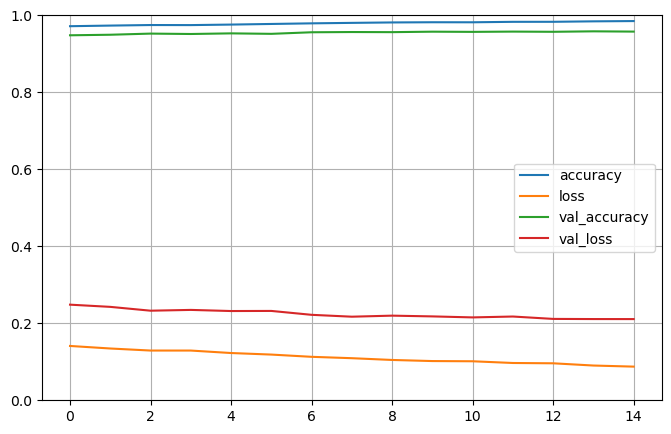

In [118]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) #sets vertical range from [0-1]
plt.show()

In [119]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9856 - loss: 0.0836 - val_accuracy: 0.9604 - val_loss: 0.2082
Epoch 2/15
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9860 - loss: 0.0806 - val_accuracy: 0.9587 - val_loss: 0.2076
Epoch 3/15
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9871 - loss: 0.0794 - val_accuracy: 0.9605 - val_loss: 0.2061
Epoch 4/15
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9876 - loss: 0.0768 - val_accuracy: 0.9617 - val_loss: 0.2043
Epoch 5/15
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9881 - loss: 0.0745 - val_accuracy: 0.9600 - val_loss: 0.2048
Epoch 6/15
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9881 - loss: 0.0737 - val_accuracy: 0.9579 - val_loss: 0.2046
Epoch 7/15
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9868 - loss: 0.0742 - val_accuracy: 0.9613 - val_loss: 0.2019
Epoch 8/15
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9883 - loss: 0.0702 - val_accuracy: 0.

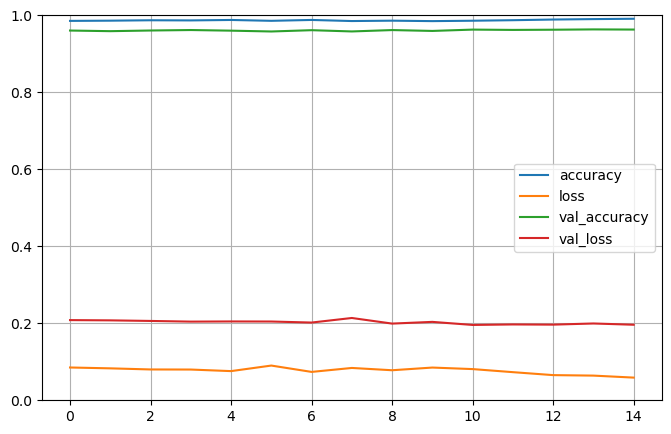

In [120]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) #sets vertical range from [0-1]
plt.show()

In [121]:
model.evaluate(X_test, y_test)

395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.8665 - loss: 0.8298


[0.8376697897911072, 0.8667458295822144]

In [122]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.98, 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [131]:
internet_img_path = "internet_pictures/dig.jpg"
image = cv2.imread(internet_img_path)

def predict_image(image):
    image = cv2.resize(image, (32, 32))  # Resize to the target size
    image = image / 255.0  # Normalize the image data
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict the class of the image
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)

    print(f"Predicted Class: {predicted_class}")
    
predict_image(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted Class: 25
